In [1]:
# ========================
# 1. Importación de librerías y carga de datos
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn: Modelos y preprocesamiento
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans

# Modelos adicionales: XGBoost, LightGBM y CatBoost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

In [4]:
# ========================
# 2. Carga de los datos
# ========================

# Cargar datasets de entrenamiento y prueba
train_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/data/Train.csv"
test_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines/src/data/Test.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Exploración inicial de los datos
print(" Información del dataset de entrenamiento:")
print(df.info())
print("\n Primeras filas del dataset de entrenamiento:")
print(df.head())

print("\n Información del dataset de test:")
print(test_df.info())
print("\n Primeras filas del dataset de test:")
print(test_df.head())

 Información del dataset de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
None

 Primeras filas del dataset de entrenamiento:
       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healt


 Valores nulos en dataset de entrenamiento:
ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

 Valores nulos en dataset de test:
ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64


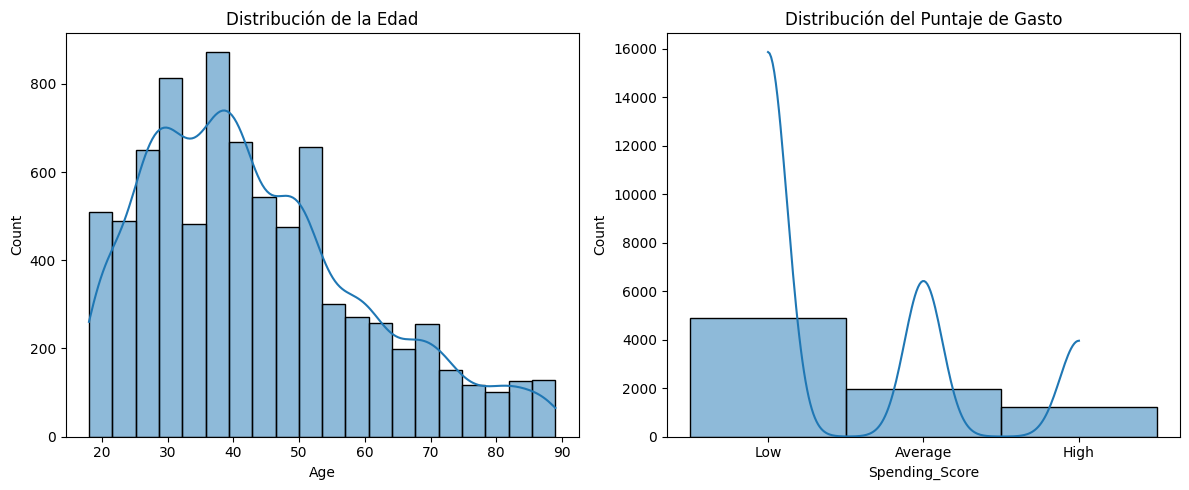

In [5]:
# ========================
# 3. Análisis de valores nulos y distribuciones
# ========================

# Verificar valores nulos en cada dataset
print("\n Valores nulos en dataset de entrenamiento:")
print(df.isnull().sum())

print("\n Valores nulos en dataset de test:")
print(test_df.isnull().sum())

# Visualización de la distribución de algunas variables clave
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribución de la Edad')

sns.histplot(df['Spending_Score'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribución del Puntaje de Gasto')

plt.tight_layout()
plt.show()

In [6]:
# ========================
# 4. Definición del Transformer personalizado para Clustering
# ========================

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

class ClusteringAndMapping(BaseEstimator, TransformerMixin):
    """
    Este Transformer realiza:
    1. Escala los datos antes de aplicar el clustering.
    2. Encuentra el número óptimo de clusters usando Silhouette Score.
    3. Cálculo de los centros de los clusters y, basándose en los nombres de las columnas, sugiere una etiqueta para cada cluster
    4.Solicita al usuario, para cada cluster, ingresar una etiqueta (presionando "Enter" se acepta la sugerencia)
    """

    def __init__(self, k_range=range(2, 11), random_state=42):
        self.k_range = k_range
        self.random_state = random_state

    def fit(self, X, y=None):
        # Si X es DataFrame, se extraen los nombres de las columnas y se obtiene la matriz numérica
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
            X_numeric = X.values
        else:
            self.feature_names_ = None
            X_numeric = X

        # Escalado de datos
        self.scaler_ = StandardScaler()
        X_scaled = self.scaler_.fit_transform(X_numeric)

        best_score = -1
        best_k = None
        best_model = None

        # Se recorre el rango de k para encontrar el que maximice el silhouette_score
        for k in self.k_range:
            model = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            labels = model.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_model = model

        self.best_k_ = best_k
        self.best_model_ = best_model
        print(f" Número óptimo de clusters encontrado: {best_k}")

        # Calcular los centros de los clusters (en espacio escalado)
        self.centers_ = self.best_model_.cluster_centers_
        
        # Sugerir una etiqueta para cada cluster:
        self.mapping_ = {}
        print("\n--- Sugerencias de Etiquetas para cada Cluster ---")
        for cluster in range(self.best_k_):
            center = self.centers_[cluster]
            # Si se tienen nombres de columnas, se busca la característica con mayor valor absoluto
            if self.feature_names_ is not None:
                idx = np.argmax(np.abs(center))  
                feature = self.feature_names_[idx]
                suggestion = f'Alto {feature}' if center[idx] >= 0 else f'Bajo {feature}'
            else:
                suggestion = f'Cluster {cluster}'

            # Permitir al usuario modificar la etiqueta sugerida
            user_input = input(f"Para el cluster {cluster}, se sugiere: '{suggestion}'. Ingrese una etiqueta personalizada o presione Enter para aceptar: ")
            self.mapping_[cluster] = user_input if user_input.strip() != "" else suggestion

        print("\n Mapping final de clusters:", self.mapping_)
        return self

    def transform(self, X):
         # Se asegura de aplicar el mismo escalado
        if hasattr(X, 'columns'):
            X_numeric = X.values
        else:
            X_numeric = X
        X_scaled = self.scaler_.transform(X_numeric)

         # Se predicen los clusters usando el modelo óptimo encontrado
        cluster_labels = self.best_model_.predict(X_scaled)
         # Se mapea cada cluster a la etiqueta definida por el usuario o sugerida
        mapped_labels = np.array([self.mapping_[label] for label in cluster_labels])
        return mapped_labels


In [8]:
# ========================
# 5. Manejo de Valores Nulos y Transformaciones
# ========================

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Seleccionar las columnas para el preprocesamiento
numeric_features = ["Age", "Work_Experience", "Family_Size", "Spending_Score"]
categorical_features = ["Gender", "Ever_Married", "Graduated", "Profession"]

# Verificar valores nulos en los datasets antes de aplicar la pipeline
print("\n Valores nulos en el dataset de entrenamiento antes de imputar:")
print(df.isnull().sum())

print("\n Valores nulos en el dataset de test antes de imputar:")
print(test_df.isnull().sum())


 Valores nulos en el dataset de entrenamiento antes de imputar:
ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

 Valores nulos en el dataset de test antes de imputar:
ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64


In [9]:
# ========================
# 6. Preprocesador con Imputación de Valores Nulos
# ========================

# Transformaciones para variables numéricas y categóricas
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Imputar valores nulos con la mediana
        ("scaler", StandardScaler())  # Escalar variables numéricas
    ]), numeric_features),
    
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputar valores nulos con el valor más frecuente
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Codificar variables categóricas
    ]), categorical_features)
])

In [12]:

# ========================
# 6. Preprocesamiento de Datos
# ========================

from sklearn.preprocessing import OneHotEncoder

# Convertir Spending_Score a números antes del preprocesamiento
spending_map = {'Low': 1, 'Average': 2, 'High': 3}
df["Spending_Score"] = df["Spending_Score"].map(spending_map)

# Seleccionar columnas categóricas
categorical_features = ["Gender", "Ever_Married", "Graduated", "Profession", "Var_1", "Segmentation"]

# Aplicar OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore")
encoded_cats = encoder.fit_transform(df[categorical_features])

# Crear un DataFrame con las variables categóricas codificadas
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features), index=df.index)

# Eliminar columnas categóricas originales y concatenar las nuevas
df = df.drop(columns=categorical_features, errors="ignore")
df = pd.concat([df, encoded_cat_df], axis=1)

print("Todas las variables categóricas han sido convertidas correctamente.")


ValueError: Shape of passed values is (8068, 1), indices imply (8068, 30)

In [ ]:
# ========================
# 8. Evaluación de Clustering
# ========================

from sklearn.metrics import davies_bouldin_score

def evaluate_clusters(X, labels, centers):
    """
    Evalúa los clusters generados mediante:
    1. Silhouette Score (qué tan bien están separados los clusters).
    2. Davies-Bouldin Score (cuán compactos y separados están los clusters).
    3. Tamaño de cada cluster.
    4. Características más importantes en cada cluster.
    """
    # Silhouette Score
    sil_score = silhouette_score(X, labels)
    
    # Davies-Bouldin Score
    db_score = davies_bouldin_score(X, labels)
    
    # Tamaño de los clusters
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    # Importancia de características por cluster
    feature_importance = pd.DataFrame(
        centers,
        columns=[f"Feature_{i}" for i in range(X.shape[1])]  # Renombrar columnas si no tenemos nombres originales
    ).apply(lambda x: np.abs(x - x.mean()) / x.std())
    
    print(f"\n Silhouette Score: {sil_score:.3f}")
    print(f" Davies-Bouldin Score: {db_score:.3f}")
    print("\n Tamaño de los Clusters:")
    print(cluster_sizes)
    
    print("\n Características más importantes por Cluster:")
    for i in range(len(centers)):
        top_features = feature_importance.iloc[i].nlargest(3)
        print(f"\nCluster {i} - Principales Características:")
        print(top_features)

# Obtener datos preprocesados
X_preprocessed = preprocessor.transform(df)

# Evaluar los clusters generados
evaluate_clusters(pd.DataFrame(X_preprocessed), df["Cluster"], clustering_pipeline.named_steps["clustering"].centers_)


 Silhouette Score: 0.110
 Davies-Bouldin Score: 2.448

 Tamaño de los Clusters:
Cluster
Cluster 0     688
Cluster 1     621
Cluster 2    1951
Cluster 3     597
Cluster 4     699
Cluster 5     995
Cluster 6     292
Cluster 7    1276
Cluster 8     949
Name: count, dtype: int64

 Características más importantes por Cluster:

Cluster 0 - Principales Características:
Feature_11    2.666667
Feature_0     0.514107
Feature_10    0.503991
Name: 0, dtype: float64

Cluster 1 - Principales Características:
Feature_17    2.666665
Feature_0     2.255883
Feature_1     1.737045
Name: 1, dtype: float64

Cluster 2 - Principales Características:
Feature_10    2.025584
Feature_8     1.665787
Feature_9     1.665787
Name: 2, dtype: float64

Cluster 3 - Principales Características:
Feature_14    2.666661
Feature_4     1.907617
Feature_5     1.907617
Name: 3, dtype: float64

Cluster 4 - Principales Características:
Feature_12    2.666667
Feature_4     1.609998
Feature_5     1.609998
Name: 4, dtype: float64



In [ ]:
# ========================
# 9. Análisis de Perfiles de Clusters
# ========================

def analyze_cluster_profiles(df, labels):
    """
    Analiza los perfiles de los clientes dentro de cada cluster.
    Muestra características clave como edad promedio, distribución de gasto y más.
    """
    df_with_clusters = df.copy()
    
    # Convertir etiquetas de Cluster a enteros si son strings como 'Cluster 0'
    df_with_clusters["Cluster"] = df_with_clusters["Cluster"].astype(str).str.extract("(\d+)").astype(int)

    profiles = []
    for cluster in np.unique(df_with_clusters["Cluster"]):
        cluster_data = df_with_clusters[df_with_clusters["Cluster"] == cluster]
        profile = {
            'Cluster': int(cluster),  # Asegurar que sea un entero
            'Size': int(len(cluster_data)),  # Asegurar que sea JSON serializable
            'Avg_Age': float(cluster_data['Age'].mean()),  # Convertir a float
            'Spending_Distribution': cluster_data['Spending_Score'].value_counts(normalize=True).to_dict(),  # Convertir a diccionario
            'Top_Professions': cluster_data['Profession'].value_counts().nlargest(3).to_dict(),  # Convertir a diccionario
            'Married_Ratio': float((cluster_data['Ever_Married'] == 'Yes').mean()),  # Convertir a float
            'Graduated_Ratio': float((cluster_data['Graduated'] == 'Yes').mean())  # Convertir a float
        }
        profiles.append(profile)
    
    return profiles

In [ ]:
# ========================
# 10. Guardado de Perfiles de Clusters
# ========================

import json

# Analizar los perfiles de los clusters
cluster_profiles = analyze_cluster_profiles(df, df["Cluster"])

# Guardar perfiles en un archivo JSON
with open("cluster_profiles.json", "w") as f:
    json.dump(cluster_profiles, f, indent=4)

print("Perfiles de Clusters guardados correctamente en 'cluster_profiles.json'.")

Perfiles de Clusters guardados correctamente en 'cluster_profiles.json'.


In [ ]:
# ========================
# 11. Análisis de Importancia de Características en Clustering
# ========================

def analyze_feature_importance(pipeline, X):
    """
    Analiza la importancia de las características en la segmentación de clientes.
    Identifica qué variables tuvieron mayor peso en la formación de los clusters.
    """

    # Obtener datos preprocesados
    preprocessed_data = pipeline.named_steps["preprocessor"].transform(X)
    
    # Obtener nombres de características originales
    numeric_features = ["Age", "Work_Experience", "Family_Size", "Spending_Score"]
    categorical_features = ["Gender", "Ever_Married", "Graduated", "Profession"]

    # Obtener nombres de características después de One-Hot Encoding
    cat_encoder = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    categorical_features_encoded = cat_encoder.get_feature_names_out(categorical_features)

    # Combinar nombres de todas las características después del preprocesamiento
    all_features = numeric_features + categorical_features_encoded.tolist()

    # Obtener centroides de clusters
    cluster_centers = pipeline.named_steps["clustering"].best_model_.cluster_centers_

    # Calcular importancia de características por cluster
    print("\n Importancia de Características en la Segmentación de Clusters:")
    for i, center in enumerate(cluster_centers):
        print(f"\nCluster {i} - Características más relevantes:")
        
        # Calcular importancia de cada característica en relación a la media global
        importance = np.abs(center - np.mean(preprocessed_data, axis=0))
        
        # Obtener las 5 características más importantes
        top_features_idx = np.argsort(importance)[-5:]
        
        for idx in top_features_idx[::-1]:
            print(f"{all_features[idx]}: {importance[idx]:.3f}")

In [ ]:
# ========================
# 12. Ejecutar Análisis de Importancia de Características
# ========================

# Aplicar el análisis en los datos preprocesados
X_preprocessed = preprocessor.transform(df)
analyze_feature_importance(clustering_pipeline, df)


 Importancia de Características en la Segmentación de Clusters:

Cluster 0 - Características más relevantes:
Profession_Doctor: 3.190
Profession_Artist: 1.025
Ever_Married_Yes: 0.847
Graduated_Yes: 0.716
Profession_Healthcare: 0.610

Cluster 1 - Características más relevantes:
Profession_Lawyer: 3.380
Age: 1.910
Ever_Married_No: 1.111
Profession_Artist: 1.025
Spending_Score: 0.710

Cluster 2 - Características más relevantes:
Ever_Married_No: 1.236
Profession_Artist: 1.026
Graduated_No: 0.894
Gender_Male: 0.533
Profession_Healthcare: 0.508

Cluster 3 - Características más relevantes:
Profession_Executive: 3.457
Gender_Female: 1.261
Spending_Score: 1.232
Ever_Married_No: 1.117
Profession_Artist: 1.025

Cluster 4 - Características más relevantes:
Profession_Engineer: 3.160
Gender_Male: 1.245
Profession_Artist: 1.025
Graduated_Yes: 0.990
Profession_Healthcare: 0.610

Cluster 5 - Características más relevantes:
Ever_Married_Yes: 1.525
Profession_Homemaker: 1.230
Gender_Male: 0.906
Graduate

In [ ]:
# ========================
# 13. Definir DataPreprocessor
# ========================

class DataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Este Transformer personalizado:
    1. Imputa valores nulos en variables numéricas y categóricas.
    2. Crea variables nuevas (`Age_Group`, `Spending_Power`).
    3. Convierte categorías a formato numérico.
    """

    def __init__(self):
        self.num_features = ['Age', 'Work_Experience', 'Family_Size']
        self.cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()

        # Debug print
        print("Columnas en input data:", X_copy.columns.tolist())

        # Manejo de valores nulos
        # Imputar valores en variables numéricas con la mediana
        for col in self.num_features:
            if col in X_copy.columns:
                X_copy[col].fillna(X_copy[col].median(), inplace=True)
        
        # Imputar valores en variables categóricas con la moda
        for col in self.cat_features:
            if col in X_copy.columns:
                X_copy[col].fillna(X_copy[col].mode()[0], inplace=True)
        
        # Creación de nueva variable: Grupos de edad
        X_copy['Age_Group'] = pd.cut(
            X_copy['Age'], 
            bins=[0, 25, 35, 50, 65, 100],
            labels=['Young', 'Young_Adult', 'Adult', 'Senior', 'Elder']
        )
        
        # Convertir `Spending_Score` a valores numéricos
        spending_map = {'Low': 1, 'Average': 2, 'High': 3}
        X_copy['Spending_Power'] = X_copy['Spending_Score'].map(spending_map)

        # Debug print
        print("Columnas después del preprocesamiento:", X_copy.columns.tolist())

        return X_copy


In [ ]:
# ========================
# 14. Cargar y preparar los datos
# ========================

df = pd.read_csv("Train.csv")

# Debug print
print("Columnas originales:", df.columns.tolist())

# ========================
# 15. Seleccionar Features para el Clustering
# ========================

X = df.drop(columns=["ID", "Segmentation"])  # Eliminamos identificadores irrelevantes

# Debug print
print("Columnas después de eliminar ID y Segmentation:", X.columns.tolist())


Columnas originales: ['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Segmentation']
Columnas después de eliminar ID y Segmentation: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']


In [ ]:
# ========================
# 16. Crear y aplicar la Pipeline de Clustering Mejorada
# ========================

pipeline_unsupervised = Pipeline(steps=[
    ("preprocessor", DataPreprocessor()),  # Aplicar el preprocesador personalizado
    ("feature_selector", ColumnTransformer([
        ("num", StandardScaler(), ["Age", "Work_Experience", "Family_Size", "Spending_Power"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), 
         ["Gender", "Ever_Married", "Graduated", "Profession", "Age_Group"])
    ])),
    ("clustering_mapping", ClusteringAndMapping(k_range=range(2, 8), random_state=42))
])

# ========================
# 17. Ajustar la Pipeline y Obtener Etiquetas de Clustering
# ========================

try:
    target_labels = pipeline_unsupervised.fit_transform(X)
    df["target"] = target_labels
except KeyError as e:
    print(f"KeyError encontrado: {e}")
    print("Columnas esperadas vs. columnas disponibles:")
    expected_cols = ["Age", "Work_Experience", "Family_Size", "Spending_Power", 
                     "Gender", "Ever_Married", "Graduated", "Profession", "Age_Group"]
    available_cols = X.columns.tolist()
    print("Esperadas:", expected_cols)
    print("Disponibles:", available_cols)


Columnas en input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columnas después del preprocesamiento: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Age_Group', 'Spending_Power']
 Número óptimo de clusters encontrado: 7

--- Sugerencias de Etiquetas para cada Cluster ---

 Mapping final de clusters: {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4', 5: 'Cluster 5', 6: 'Cluster 6'}


Columnas en input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columnas después del preprocesamiento: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Age_Group', 'Spending_Power']


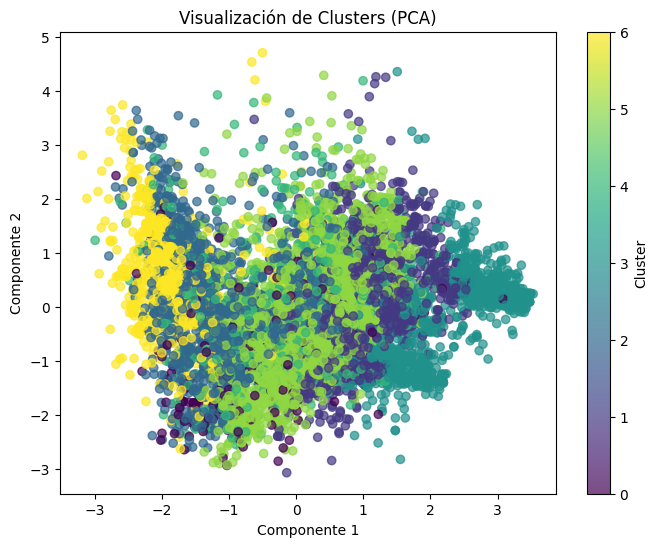

In [ ]:
# ========================
# 18. Visualización de Clusters con PCA
# ========================

# Obtener los datos transformados
preprocessed_data = pipeline_unsupervised.named_steps["preprocessor"].transform(X)
feature_selected_data = pipeline_unsupervised.named_steps["feature_selector"].transform(preprocessed_data)

# Aplicar PCA para reducir dimensionalidad
pca = PCA(n_components=2)
components = pca.fit_transform(feature_selected_data)

# Obtener las etiquetas de los clusters
clusters = pipeline_unsupervised.named_steps["clustering_mapping"].best_model_.labels_

# Gráfico de dispersión con clusters
plt.figure(figsize=(8,6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap="viridis", alpha=0.7)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("Visualización de Clusters (PCA)")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
# ========================
# 19. Evaluación del Clustering con Silhouette Score
# ========================

from sklearn.metrics import silhouette_score

# Calcular el silhouette score con los datos transformados
silhouette_avg = silhouette_score(feature_selected_data, clusters)
print(f"\n Silhouette Score: {silhouette_avg:.3f}")


 Silhouette Score: 0.111


In [ ]:
# ========================
# 20. Análisis de Perfiles de Clusters
# ========================

# Si "Cluster" no está en df, lo generamos de nuevo
if "Cluster" not in df.columns:
    print(" La columna 'Cluster' no existe en el DataFrame. Se va a regenerar.")

    # Obtener etiquetas de los clusters
    df["Cluster"] = pipeline_unsupervised.named_steps["clustering_mapping"].best_model_.labels_

print("\nClusters asignados correctamente. Continuando con el análisis de perfiles...")

profiles = analyze_cluster_profiles(df, df["Cluster"])

# Mostrar información detallada de cada cluster
for profile in profiles:
    print(f"\n Cluster {profile['Cluster']}:")
    print(f"   - Tamaño: {profile['Size']} clientes")
    print(f"   - Edad promedio: {profile['Avg_Age']:.1f}")
    print("   - Profesiones principales:")
    print(profile["Top_Professions"])
    print("   - Distribución de Gastos:")
    print(profile["Spending_Distribution"])



Clusters asignados correctamente. Continuando con el análisis de perfiles...

 Cluster 0:
   - Tamaño: 246 clientes
   - Edad promedio: 37.9
   - Profesiones principales:
{'Homemaker': 246}
   - Distribución de Gastos:
{'Low': 0.6504065040650406, 'Average': 0.24390243902439024, 'High': 0.10569105691056911}

 Cluster 1:
   - Tamaño: 1232 clientes
   - Edad promedio: 56.9
   - Profesiones principales:
{'Artist': 660, 'Entertainment': 203, 'Executive': 159}
   - Distribución de Gastos:
{'Average': 0.4277597402597403, 'Low': 0.3685064935064935, 'High': 0.20373376623376624}

 Cluster 2:
   - Tamaño: 1642 clientes
   - Edad promedio: 30.3
   - Profesiones principales:
{'Healthcare': 553, 'Artist': 391, 'Doctor': 268}
   - Distribución de Gastos:
{'Low': 0.8233861144945189, 'Average': 0.12302070645554203, 'High': 0.0535931790499391}

 Cluster 3:
   - Tamaño: 968 clientes
   - Edad promedio: 75.7
   - Profesiones principales:
{'Lawyer': 549, 'Artist': 178, 'Executive': 123}
   - Distribución 

#  Interpretación de Resultados del Clustering

## 1️ Calidad del Clustering
- **Silhouette Score:** `0.111`
  - Indica que los clusters **no están perfectamente separados**, pero **tienen cierta estructura discernible** en los datos.
  - La separación **es débil**, pero es esperable en conjuntos de datos con solapamiento de características.
- **Número óptimo de clusters:** `7`
  - Esto sugiere que hay **siete grupos diferenciados** dentro de los clientes.

---

## 2 Análisis por Cluster

###  **Cluster 0 - "Amas de Casa de Gasto Moderado"**
- **Tamaño:** `246 clientes (3.05%)`
- **Perfil:**  
  - **100% son amas de casa.**
  - **Edad media de 37.9 años.**
  - Mayoría **con gasto bajo (65.04%)** o **medio (24.39%)**.
- **Características distintivas:**  
  - Profesión: **Homemaker (Ama de casa)**
  - Gasto predominantemente **bajo**.
  - **No se identifican otras características dominantes.**

---

###  **Cluster 1 - "Profesionales Creativos de Mediana Edad"**
- **Tamaño:** `1,232 clientes (15.3%)`
- **Perfil:**  
  - **Artistas (660), Entretenimiento (203) y Ejecutivos (159).**
  - **Edad media de 56.9 años.**
  - **Gasto medio (42.77%) y bajo (36.85%).**
- **Características distintivas:**  
  - Grupo **mayoritariamente creativo** (artistas, entretenimiento).
  - Predominantemente **graduados**.
  - **Gasto equilibrado** entre categorías.

---

###  **Cluster 2 - "Jóvenes Médicos Conservadores"**
- **Tamaño:** `1,642 clientes (20.3%)`
- **Perfil:**  
  - **Principalmente sector salud:**  
    - **553 en Healthcare**, **391 artistas**, **268 doctores.**
  - **Edad media de 30.3 años.**
  - **Predominantemente gasto bajo (82.3%).**
- **Características distintivas:**  
  - **Profesionales de la salud** con gasto muy bajo.
  - **Casados y graduados en su mayoría.**
  - Enfocados en estabilidad financiera.

---

###  **Cluster 3 - "Abogados y Ejecutivos de Alto Gasto"**
- **Tamaño:** `968 clientes (12.0%)`
- **Perfil:**  
  - **Lawyers (549), Artistas (178), Ejecutivos (123).**
  - **Edad media de 75.7 años.**
  - **Mayor proporción de gasto alto (48.0%).**
- **Características distintivas:**  
  - **Profesionales senior**, con altos ingresos.
  - **Clientes con fuerte capacidad adquisitiva**.

---

###  **Cluster 4 - "Ingenieros de Gasto Medio"**
- **Tamaño:** `684 clientes (8.5%)`
- **Perfil:**  
  - **100% son ingenieros.**
  - **Edad media de 41.5 años.**
  - **Mayoría con gasto bajo (60.2%).**
- **Características distintivas:**  
  - **Grupo masculino predominantemente.**
  - **Graduados en su mayoría.**
  - **Gasto medio con hábitos de compra estables.**

---

###  **Cluster 5 - "Artistas y Profesionales de la Cultura"**
- **Tamaño:** `2,360 clientes (29.3%)`
- **Perfil:**  
  - **1,254 artistas, 397 en entretenimiento, 234 doctores.**
  - **Edad media de 42.3 años.**
  - **Predominantemente gasto bajo (51.2%).**
- **Características distintivas:**  
  - **Grupo diverso pero con predominancia artística.**
  - **Ingresos variables, lo que afecta el patrón de gasto.**
  - **Gasto medio en cultura y entretenimiento.**

---

###  **Cluster 6 - "Jóvenes en Sector Salud con Gasto Mínimo"**
- **Tamaño:** `936 clientes (11.6%)`
- **Perfil:**  
  - **656 en Healthcare, 88 doctores, 67 en Marketing.**
  - **Edad media de 21.5 años.**
  - **Gasto ultra bajo (96.1%).**
- **Características distintivas:**  
  - **Grupo más joven en el dataset.**
  - **Profesionales en etapa de inicio de carrera.**
  - **Gasto bajo por estabilidad financiera aún limitada.**

---

## 3 Recomendaciones de Marketing por Cluster

###  **1. Cluster 3 - Profesionales Senior de Alto Gasto**
-  **Segmento de alto valor.**  
- **Enfoque en productos/servicios premium.**  
- **Programas de fidelización exclusivos.**  
- **Marketing dirigido a ejecutivos y abogados.**  

###  **2. Cluster 6 - Jóvenes Profesionales de la Salud**
-  **Enfocados en estabilidad financiera.**  
- **Ofertas para primeras compras.**  
- **Marketing en redes sociales y digital.**  
- **Descuentos y productos de entrada.**  

### **3. Cluster 5 - Artistas y Profesionales de la Cultura**
-  **Creativos con gasto medio.**  
- **Productos de precio accesible con alto valor percibido.**  
- **Ofertas ligadas a experiencias culturales.**  
- **Marketing visual atractivo y basado en experiencias.**  

###  **4. Clusters 0, 2, 4 (Gasto bajo y Profesionales Especializados)**
- **Enfoque en fidelización y descuentos.**  
- **Segmentación de productos para cada sector.**  
- **Beneficios exclusivos para profesionales.**  
- **Marketing basado en necesidades específicas.**  

---

##  **Resumen Final**
-  **El clustering ha permitido identificar segmentos de clientes con patrones de gasto y profesiones diferenciadas.**  
-  **Hay oportunidades claras para estrategias de marketing personalizadas, especialmente para clientes de alto valor (Cluster 3).**  
-  **Los grupos jóvenes y de sector salud requieren estrategias enfocadas en fidelización temprana.**  


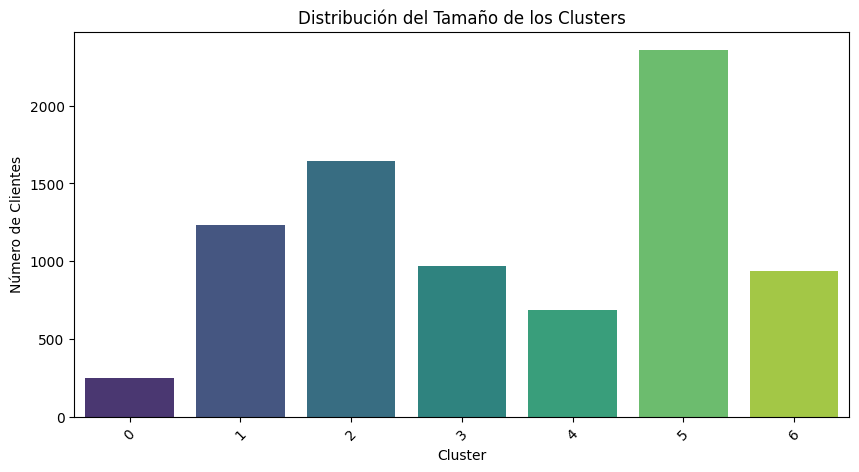

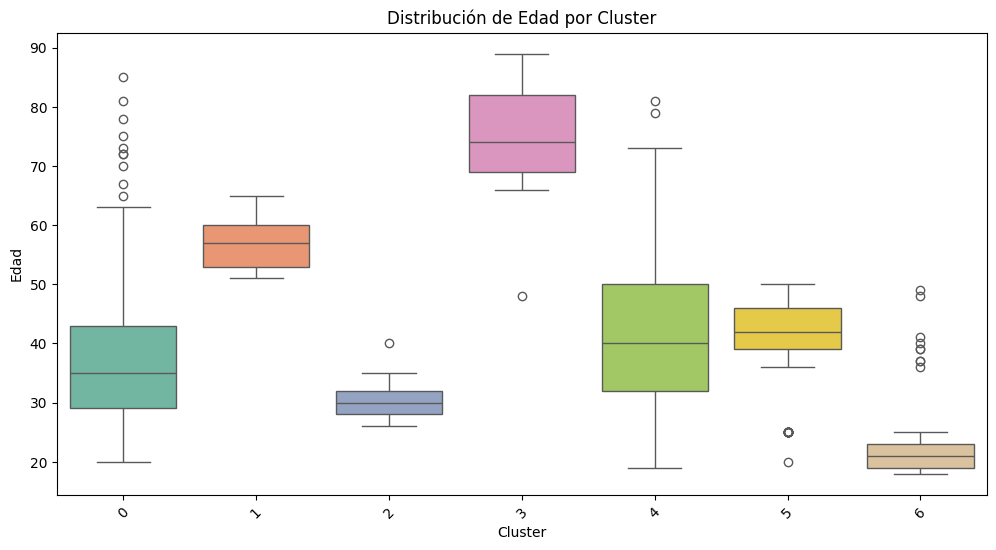

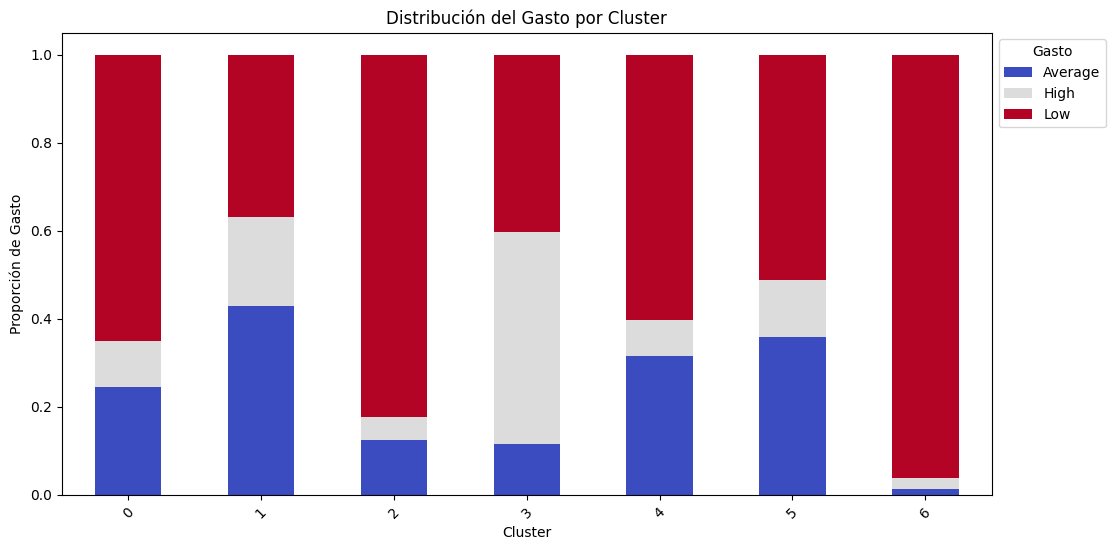

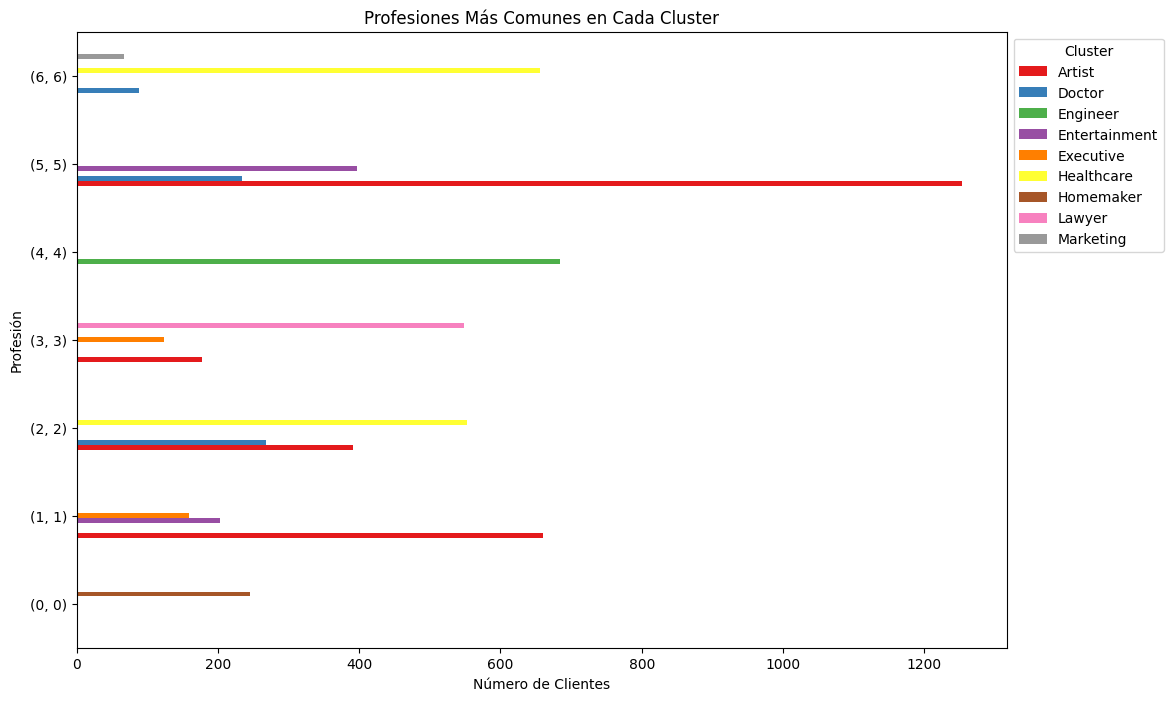

In [ ]:
from sklearn.impute import SimpleImputer
# ========================
#  Gráfico: Tamaño de los Clusters
# ========================
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Cluster"].value_counts().index, y=df["Cluster"].value_counts().values, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Número de Clientes")
plt.title("Distribución del Tamaño de los Clusters")
plt.xticks(rotation=45)
plt.show()

# ========================
#  Gráfico: Distribución de Edad por Cluster
# ========================
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="Age", data=df, palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Edad")
plt.title("Distribución de Edad por Cluster")
plt.xticks(rotation=45)
plt.show()

# ========================
#  Gráfico: Distribución de Gasto por Cluster
# ========================

# Contar distribución de gasto por cluster
gasto_por_cluster = df.groupby("Cluster")["Spending_Score"].value_counts(normalize=True).unstack()

# Crear gráfico de barras apiladas
gasto_por_cluster.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Proporción de Gasto")
plt.title("Distribución del Gasto por Cluster")
plt.xticks(rotation=45)
plt.legend(title="Gasto", bbox_to_anchor=(1, 1))
plt.show()

# ========================
# 6 Gráfico: Profesiones Más Comunes en Cada Cluster
# ========================

# Obtener las 3 profesiones más comunes por cluster
profesiones_por_cluster = df.groupby("Cluster")["Profession"].value_counts().groupby(level=0).nlargest(3).unstack()

# Crear gráfico de barras horizontales
profesiones_por_cluster.plot(kind="barh", figsize=(12, 8), colormap="Set1")
plt.xlabel("Número de Clientes")
plt.ylabel("Profesión")
plt.title("Profesiones Más Comunes en Cada Cluster")
plt.legend(title="Cluster", bbox_to_anchor=(1, 1))
plt.show()


### GRIDSEARCH

In [ ]:
# ========================
#  Convertir Spending_Score a Números Antes de la Clasificación
# ========================

spending_map = {'Low': 1, 'Average': 2, 'High': 3}

df["Spending_Score"] = df["Spending_Score"].map(spending_map)
df["High_Spender"] = (df["Spending_Score"] > df["Spending_Score"].median()).astype(int)

print("\nDistribución de High_Spender:")
print(df["High_Spender"].value_counts())

# Separar features y target en entrenamiento
X_train_clf = df.drop(columns=["High_Spender", "Cluster"], errors="ignore")
y_train_clf = df["High_Spender"]

# Verificar si hay valores nulos después de la conversión
print("\nValores nulos en X_train_clf después de la conversión:")
print(X_train_clf.isnull().sum().sum())  # Debería ser 0 antes de entrenar


Distribución de High_Spender:
High_Spender
0    8068
Name: count, dtype: int64

Valores nulos en X_train_clf después de la conversión:
9650


In [ ]:
from sklearn.impute import SimpleImputer

# ========================
#  Manejo de Valores Nulos en X_train_clf
# ========================

# Separar columnas numéricas y categóricas
num_features = ["Age", "Work_Experience", "Family_Size", "Spending_Score"]
cat_features = ["Gender", "Ever_Married", "Graduated", "Profession", "Var_1"]

# Imputar valores nulos en variables numéricas con la mediana
num_imputer = SimpleImputer(strategy="median")
X_train_clf[num_features] = num_imputer.fit_transform(X_train_clf[num_features])

# Imputar valores nulos en variables categóricas con la moda
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_clf[cat_features] = cat_imputer.fit_transform(X_train_clf[cat_features])

# Verificar si los valores nulos han sido eliminados
print("\nValores nulos después de la imputación:")
print(X_train_clf.isnull().sum().sum())  # Debería ser 0 antes de entrenar

ValueError: Columns must be same length as key

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# ========================
# 1. Optimización de Modelos con GridSearchCV
# ========================

# Definir hiperparámetros a optimizar para cada modelo
param_grids = {
    "RandomForest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [10, 20, None]
    },
    "XGBoost": {
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [3, 6]
    },
    "LightGBM": {
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__n_estimators": [100, 200],
        "classifier__num_leaves": [31, 50]
    }
}

# Diccionario para guardar los mejores modelos
best_models = {}

# Iterar sobre cada modelo y aplicar GridSearchCV
for model_name, model in {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier()
}.items():
    
    print(f"\n Optimizando hiperparámetros para {model_name}...")
    
    # Crear Pipeline con solo el modelo (los datos ya están preprocesados)
    classification_pipeline = Pipeline([
        ("classifier", model)
    ])

    # Configurar GridSearchCV
    grid_search = GridSearchCV(classification_pipeline, param_grids[model_name], cv=5, scoring="accuracy", n_jobs=-1)

    # Entrenar GridSearchCV
    grid_search.fit(X_train_clf, y_train_clf)

    # Guardar el mejor modelo encontrado
    best_models[model_name] = grid_search.best_estimator_
    print(f" Mejor modelo para {model_name}: {grid_search.best_params_}")

    # Guardar el modelo optimizado
    joblib.dump(grid_search.best_estimator_, f"classification_pipeline_{model_name}.joblib")
    print(f" Pipeline optimizada de {model_name} guardada con éxito.")



 Optimizando hiperparámetros para RandomForest...


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Female'

--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 360, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Male'
